<a href="https://colab.research.google.com/github/acastellanos-ie/machine_learning_2/blob/master/feature_engineering_practice/Practice%20Solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Google Colab Configuration

**Execute this steps to configure the Google Colab environment in order to execute this notebook. It is not required if you are executing it locally and you have properly configured your local environment according to what explained in the Github Repository.**

The first step is to clone the repository to have access to all the data and files.

In [14]:
repository_url = 'https://@github.com/acastellanos-ie/machine_learning_2'

In [20]:
! git clone $repository_url

Cloning into 'machine_learning_2'...
remote: Enumerating objects: 324, done.
remote: Counting objects: 100% (324/324), done.
remote: Compressing objects: 100% (286/286), done.
remote: Total 324 (delta 173), reused 100 (delta 32), pack-reused 0
Receiving objects: 100% (324/324), 32.05 MiB | 8.32 MiB/s, done.
Resolving deltas: 100% (173/173), done.


Install the requirements

In [21]:
! pip install -Uqqr machine_learning_2/requirements.txt

     |████████████████████████████████| 84 kB 2.8 MB/s 
     |████████████████████████████████| 10.3 MB 37.2 MB/s 
     |████████████████████████████████| 15.7 MB 32 kB/s 
     |████████████████████████████████| 11.3 MB 41.7 MB/s 
     |████████████████████████████████| 23.2 MB 50.3 MB/s 
     |████████████████████████████████| 261 kB 60.3 MB/s 
     |████████████████████████████████| 61 kB 547 kB/s 
     |████████████████████████████████| 23.9 MB 14 kB/s 
     |████████████████████████████████| 173.5 MB 53 kB/s 
     |████████████████████████████████| 10.1 MB 48.9 MB/s 
     |████████████████████████████████| 62 kB 859 kB/s 
     |████████████████████████████████| 675 kB 60.7 MB/s 
     |████████████████████████████████| 596 kB 48.6 MB/s 
     |████████████████████████████████| 3.1 MB 50.4 MB/s 
     |████████████████████████████████| 102 kB 11.3 MB/s 
     |████████████████████████████████| 812 kB 47.3 MB/s 
     |████████████████████████████████| 38.2 MB 25 kB/s 
ERROR: pip's depend

Go to the practice directory



In [1]:
%cd machine_learning_2/feature_engineering_practice

/content/machine_learning_2/feature_engineering_practice


Ensure that you have the GPU runtime activated:

![](https://miro.medium.com/max/3006/1*vOkqNhJNl1204kOhqq59zA.png)

Now you have everything you need to execute the code in Colab

The following code includes some imports and configuration steps for better visualization

In [2]:
from IPython.core.display import display, HTML

display(HTML("<style>.container { width:100% !important; }</style>")) # Increase cell width
display(HTML("<style>.rendered_html { font-size: 16px; }</style>")) # Increase font size

# Larger figures

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline 

import warnings
warnings.filterwarnings('ignore') # Do not print warning messages

# Introduction

We will first contact the featuring engineering process and its impact in an ML pipeline in this first practice session.
Feature engineering is one of the essential steps of the process of developing prediction models. It is considered, by many authors, an art, and it involves human-driven design and intuition. This practice will try to uncover the most relevant issues that must be addressed and provide some guidelines to start building sound feature engineering processes for ML problems. 

The experimental dataset we are going to use is the HR Analytics Dataset. It includes explanatory variables of around 15k employees of a large company. The goal of the case study is to
model the probability of attrition (employees leaving, either on their own or because they got fired) of each employee and understand which variables are the most important ones and need to be addressed right away.

The results obtained will be helpful for the management to understand what changes they should make to their workplace to get most of their employees to stay.

For more details on the dataset and the task, see <https://www.kaggle.com/manojvijayan/feature-engineering-for-logistic-regression>.

# Data Loading and Pre-Processing

Let's load the dataset to make sense of the information we have about the employees.

In [3]:
import pandas as pd
import numpy as np
import sklearn

In [48]:
initial_hr_df = pd.read_csv("data/turnover.csv")
initial_hr_df.describe()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years
count,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000
mean,0.612834,0.716102,3.803054,201.050337,3.498233,0.144610,0.238083,0.021268
std,0.248631,0.171169,1.232592,49.943099,1.460136,0.351719,0.425924,0.144281
min,0.090000,0.360000,2.000000,96.000000,2.000000,0.000000,0.000000,0.000000
25%,0.440000,0.560000,3.000000,156.000000,3.000000,0.000000,0.000000,0.000000
50%,0.640000,0.720000,4.000000,200.000000,3.000000,0.000000,0.000000,0.000000
75%,0.820000,0.870000,5.000000,245.000000,4.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,7.000000,310.000000,10.000000,1.000000,1.000000,1.000000


In [5]:
# Keep the original dataset for later comparisons and make a copy for the FE process
hr_df = initial_hr_df

We have 10 columns: the target variable (`left`) and 9 more features to work with. Let's analyze a little bit more each of them to check if we need to clean or preprocess them.

At this point I want to provide you with a very handful library to analyze your datasets: `pandas_profiling` (for more information and how to install it, check the official documentation: https://pandas-profiling.github.io/pandas-profiling/docs/). This library will analyze your dataset, taking into account the different aspects you usually want to inspect, and it will create a report that I find very useful to: 1) better understand your data and inform your ML pipeline and 2) to create a visual dataset summary that can be included in your final report.

In [ ]:
from pandas_profiling import ProfileReport
report = ProfileReport(hr_df, minimal=False)
report

## Factorize Features

2 of the categories (`sales` and `salary`) are categorical. In addition, if we analyze the rest of the features we will see that we have three more categorical values encoded as numeric: `Work_accident`, `promotion_last_5years` and the target variable itself (`left`). Therefore, we should convert them to categorical before any further processing.

You can use the `astype` function for the conversion.

In [6]:
hr_df.dtypes

satisfaction_level       float64
last_evaluation          float64
number_project             int64
average_montly_hours       int64
time_spend_company         int64
Work_accident              int64
left                       int64
promotion_last_5years      int64
sales                     object
salary                    object
dtype: object

In [41]:
hr_df['sales'] = hr_df.sales.astype('category')
hr_df['salary'] = hr_df.salary.astype('category')
hr_df['promotion_last_5years'] = hr_df.promotion_last_5years.astype('category')
hr_df['left'] = hr_df.left.astype('category')
hr_df['Work_accident'] = hr_df.Work_accident.astype('category')

hr_df.dtypes

satisfaction_level         float64
last_evaluation            float64
number_project               int64
average_montly_hours         int64
time_spend_company           int64
Work_accident             category
left                      category
promotion_last_5years     category
sales                     category
salary                    category
satisfaction_level_bin       int64
last_evaluation_bin          int64
number_project_cat        category
time_spend_company_cat    category
dtype: object

### Advanced Factorization

The rest of the numerical values present a level of detail that may be much more fine-grained than we need. For instance, the satisfaction level can be represented by different categories (low, medium, high, ...). We will then create another "bucketized" feature for each of the numerical columns.

The following piece of code is just a demonstrative example of how to do this process. The values that I've selected for the bucketization are arbitrary. In a real example, you should either find the optimal configuration or rely on some business knowledge to define these values. 


In [8]:
hr_df['satisfaction_level_bin'] = pd.cut(hr_df['satisfaction_level'], bins=[0, 0.11, 0.35, 0.46, 0.71, 0.92,1.0], labels=[0,1,2,3,4,5]).astype('int64')
hr_df['last_evaluation_bin'] = pd.cut(hr_df['last_evaluation'], bins=[0, 0.47, 0.48, 0.65, 0.88, 0.89,1.0], labels=[0,1,2,3,4,5]).astype('int64')


In [9]:
hr_df['number_project_cat'] = hr_df['number_project'].map({2:"Low",3:"Low",4:"Medium",5:"Medium",6:"High",7:"Very_High"}).astype('category')
hr_df['time_spend_company_cat'] = hr_df['time_spend_company'].map({2:"Low",3:"Medium",4:"Medium",5:"Medium",6:"High",7:"High",8:"Very_High",10:"Very_High"}).astype('category')

## Hunting NAs

There is not any NULL values, so we can skip this step. You can see by summarizing the dataset or you can use the `isnull` function to identify the null values.

In [36]:
hr_df.isnull().sum()

satisfaction_level        0
last_evaluation           0
number_project            0
average_montly_hours      0
time_spend_company        0
Work_accident             0
left                      0
promotion_last_5years     0
sales                     0
salary                    0
satisfaction_level_bin    0
last_evaluation_bin       0
number_project_cat        0
time_spend_company_cat    0
dtype: int64

It is unlikely not to have any null values in the dataset (this is a reduced and rather clean dataset of the original one). In the case that you have null values, you should follow some of the imputation/removal strategies explained in class. 


## Feature Encoding

As we have some categorical values with strings, we need to encode them to apply the sklearn classifiers. 

Additionally, let's perform the Scaling of the numerical features.

In [128]:
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline

# Define what is a categorical feature (the type of the feature is equal to object)
categorical = hr_df.columns[hr_df.dtypes=='category'].tolist()
categorical.remove('left')
numerical = hr_df.columns[hr_df.dtypes!='category'].tolist()

numeric_transformer = Pipeline(
    steps=[("standard_scaler", StandardScaler()), ("min_max_scaler", MinMaxScaler())] # Standarize and scale to [0,1] values
)

# Create a column transformer to define different transformations for each column
preprocess = make_column_transformer(
    (numeric_transformer, numerical), # StandardScaler and MinMaxScaler for non-categorical features
    (OneHotEncoder(handle_unknown='ignore'), categorical)) # OneHotEncoder for the categorical features (the handler_unknown param avoids future errors if a new category appears)

dummified_hr_df = preprocess.fit_transform(hr_df.drop(['left'], axis=1))
dummified_hr_df = pd.DataFrame(dummified_hr_df, columns=preprocess.transformers_[0][2] + preprocess.named_transformers_['onehotencoder'].get_feature_names(categorical).tolist())

dummified_hr_df.head(5)


,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,satisfaction_level_bin,last_evaluation_bin,Work_accident_0,Work_accident_1,promotion_last_5years_0,promotion_last_5years_1,sales_IT,sales_RandD,sales_accounting,sales_hr,sales_management,sales_marketing,sales_product_mng,sales_sales,sales_support,sales_technical,salary_high,salary_low,salary_medium,number_project_cat_High,number_project_cat_Low,number_project_cat_Medium,number_project_cat_Very_High,time_spend_company_cat_High,time_spend_company_cat_Low,time_spend_company_cat_Medium,time_spend_company_cat_Very_High
0,0.318681,0.265625,0.0,0.285047,0.125,0.4,0.4,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.780220,0.781250,0.6,0.775701,0.500,0.8,0.6,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
2,0.021978,0.812500,1.0,0.822430,0.250,0.0,0.6,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,0.692308,0.796875,0.6,0.593458,0.375,0.8,0.6,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,0.307692,0.250000,0.0,0.294393,0.125,0.4,0.4,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


## Outlier Analysis

Another aspect that may affect the performance of our machine learning pipeline is the presence of outliers. We will focus on the numerical columns of the dataset to detect the presence of outliers and proceed to their removal.

The easiest way to detect outliers is by visualizing the numerical values, such as `boxploting` the column values.

For instance, if we plot the `time_spend_company` feature, we will see some extreme cases of employees who have spent many years at the company. 

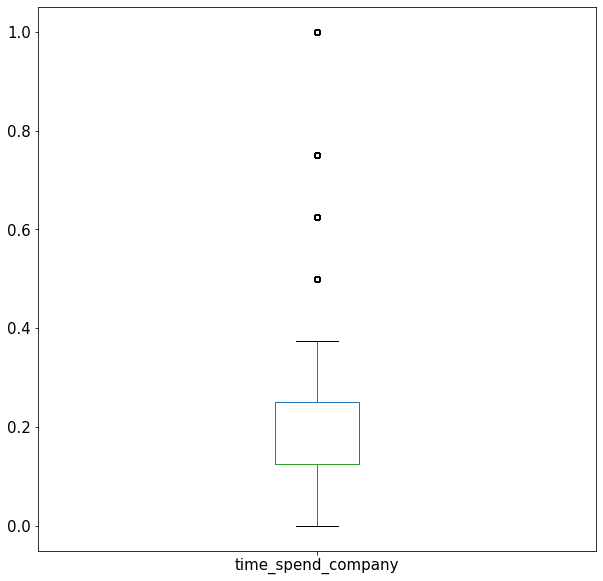

In [129]:
plt.figure(figsize=(10,10))
dummified_hr_df.boxplot(['time_spend_company'], grid=False, fontsize=15);


Usually, we don't want these extreme cases to affect or bias the training process; however, we might want to keep them in this case. Are the extreme cases meaningful? Are they related to some type of employee or behavior that we care to track? 

I leave this analysis up to you (and the analysis of the rest of the features), but in the following, I will show you a code example in case you want to visualize and remove them. Of course, removal is not the only option. You can also impute these outliers by, for instance, assign to them the average of the feature values.


In [130]:
numerical

['satisfaction_level',
 'last_evaluation',
 'number_project',
 'average_montly_hours',
 'time_spend_company',
 'satisfaction_level_bin',
 'last_evaluation_bin']

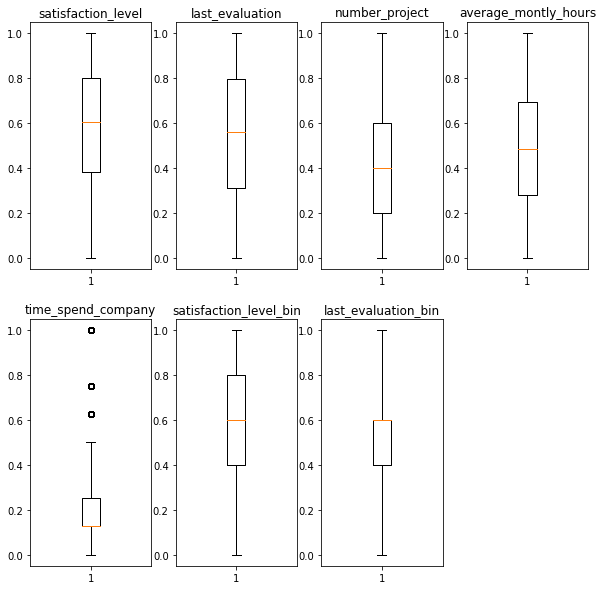

In [131]:
fig, axes = plt.subplots(2, 4, figsize=(10, 10))

for i, ax in enumerate(axes.ravel()):
    if i >= len(numerical):
        ax.set_visible(False)
        continue
    columnName = numerical[i]
    ax.boxplot(dummified_hr_df[columnName], whis=3)
    ax.set_title("{}".format(columnName))

In [132]:
from sklearn.ensemble import IsolationForest
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

outlier_free_dataset = dummified_hr_df.copy(deep=True) 
 
X,y = outlier_free_dataset, hr_df['left']
    
yhat = IsolationForest().fit_predict(X)

# select all rows that are not outliers
mask = yhat != -1

print("Number of outliers detected: " , len(np.where(mask==False)))

X_without_outliers = X[mask]
y_withouth_outliers = y[mask]

pipe = make_pipeline(LogisticRegression(max_iter=1000))
print("CV accuracy of Baseline model = {:.2}".format(np.mean(cross_val_score(pipe, X, y, cv=5))))

pipe = make_pipeline(LogisticRegression(max_iter=1000))
print("Using IsolationForest to remove outliers with CV accuracy = {:.2}".format(np.mean(cross_val_score(pipe, X_without_outliers, y_withouth_outliers, cv=5))))

Number of outliers detected:  1
CV accuracy of Baseline model = 0.86
Using IsolationForest to remove outliers with CV accuracy = 0.85


It seems that the outliers does not have a big impact. For more details, please refer to the Data Cleaning practice, but for this exercise we will focus on the feature engineering step.

# Feature Engineering

We first fit a linear model to the initial dataset to have a baseline to evaluate the data cleaning and feature engineering impact.

To facilitate the training process, we will use the `sklearn` library <https://scikit-learn.org/stable/index.html> that provides a wrapper for the preprocessing, training, and evaluation of many machine learning algorithms. 

In [133]:
initial_pipe = make_pipeline(LogisticRegression(max_iter=1000))
np.mean(cross_val_score(pipe, X, y, cv=5))

0.8553228631766144

Sklearn does not provide a handy way to plot the feature importance of the LogisticRegression models. We can work it out by extracting the values of the logreg coefficients. (Code taken from: https://stackoverflow.com/a/47191103)

In [134]:
def get_feature_importance(clf, feature_names):
    return pd.DataFrame({'variable': feature_names, # Feature names
                         'coefficient': clf.coef_[0] # Feature Coeficients
                    }) \
    .round(decimals=2) \
    .sort_values('coefficient', ascending=False) \
    .style.bar(color=['red', 'green'], align='zero')

In [135]:
initial_pipe.fit(X,y)
initial_lm_mod = initial_pipe.named_steps['logisticregression']
get_feature_importance(initial_lm_mod, X.columns)

,variable,coefficient
4,time_spend_company,6.260000
27,number_project_cat_Very_High,5.100000
30,time_spend_company_cat_Medium,2.820000
0,satisfaction_level,2.710000
29,time_spend_company_cat_Low,1.080000
28,time_spend_company_cat_High,0.850000
7,Work_accident_0,0.720000
24,number_project_cat_High,0.720000
22,salary_low,0.700000
3,average_montly_hours,0.660000


Now we can check the cross-validated accuracy of the model

In [136]:
results_df = pd.DataFrame(columns=['Approach', 'Accuracy'])
results_df.loc[len(results_df)] = ['LR Baseline', np.mean(cross_val_score(pipe, X, y, cv=5))]
results_df

,Approach,Accuracy
0,LR Baseline,0.855323


We have an accuracy close to 86%, which seems a good result to be reported to the HR department. Let's see what we can do in terms of feature engineering to improve these results.

## Filtering Methods


We will rank the features according to their predictive power by applying the methodologies seen in class: the Chi Squared Independence test and the Information Gain.

### Chi-squared Selection
Making use of the [`SelectKBest`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html) function rank the features according to the Chi Squared value. 

Does it make sense to remove some features? If so, do it!

We will start by applying the `SelectKBest` method with the `chi2` score function. This method will give a score to each feature according to its importance for predicting the target variable. 


In [137]:
from sklearn.feature_selection import SelectKBest, chi2

# Apply ChiSquared to score the features based on the training data.
chi2_selector = SelectKBest(score_func=chi2).fit(X,y)

Let's inspect what are the most important features according to ChiSquared. To that end, we need to sort the features according to the score assigned by the `chi2_selector`.

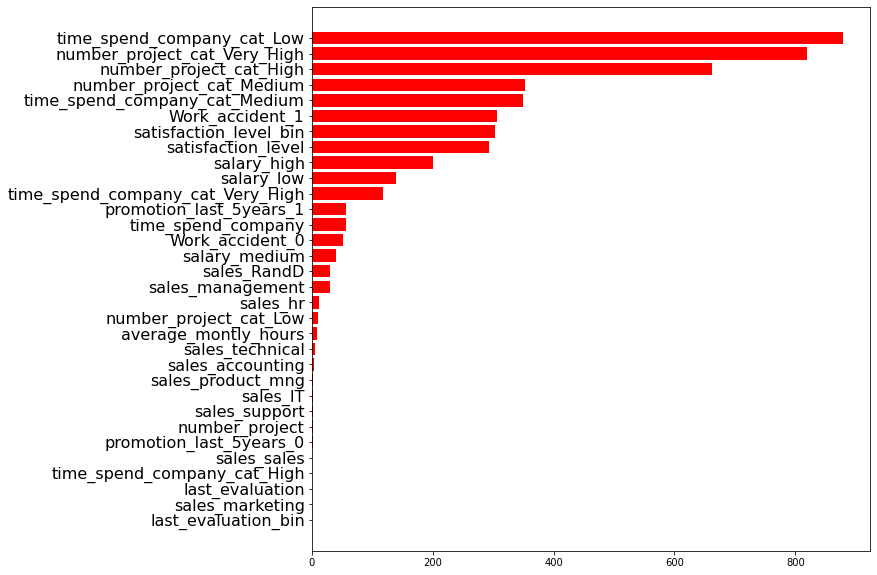

In [138]:
# Sort the features according to the ChiSquared Scores
indices = np.argsort(chi2_selector.scores_)[::-1]

# Get the Features Names of the ordered Features
chi2_features = []
for i in range(len(X.columns)):
    chi2_features.append(X.columns[indices[i]])

# Now plot
plt.figure(figsize=(10,10))
plt.yticks(rotation='horizontal',fontsize=16)
plt.barh(chi2_features, chi2_selector.scores_[indices[range(len(X.columns))]], color='r', align='center')
plt.gca().invert_yaxis()
plt.show()

This figure will allow you to inspect the feature importance according to ChiSquared. 

With this information, you can now:

- Better understand the data and how it relates to the prediction problem.
- Validate any assumption you had on the data.
- Report this information to the relevant stakeholders.

I leave to you the exercise of analyzing the results in more detail. However, at first sight, we can see that aspects such as the time spent in the company and the number of projects in which you participate appear to be strongly relevant for the employee churning. Interestingly, they seem to be more important than the salary.

As a next exercise, we are going to try to find the optimal number of features. To that end, we will start by creating a model with only the most relevant feature, then another model with the two most relevant features, and so on. This procedure is similar to the stepwise methodologies that we presented in class.

(**Note:** This is not the only way of performing the feature selection. For example, you could decide to remove the features with a score equals to 0 (i.e., they are not impacting the values of the target variable). Or perhaps you can share this info with the HR team and decide the features you want to include in the model.)

In [80]:
for i in range(1,len(chi2_features)):
    print("Features used to train the model = {}".format(i))
    print("Accuracy = {0:.4f}".format(np.mean(cross_val_score(LogisticRegression(max_iter=1000, penalty='none'), X[chi2_features[:i]], y, cv=5))))
    print()


Features used to train the model = 1
Accuracy = 0.7619

Features used to train the model = 2
Accuracy = 0.7790

Features used to train the model = 3
Accuracy = 0.7914

Features used to train the model = 4
Accuracy = 0.7914

Features used to train the model = 5
Accuracy = 0.7954

Features used to train the model = 6
Accuracy = 0.7981

Features used to train the model = 7
Accuracy = 0.7769

Features used to train the model = 8
Accuracy = 0.8193

Features used to train the model = 9
Accuracy = 0.8275

Features used to train the model = 10
Accuracy = 0.8420

Features used to train the model = 11
Accuracy = 0.8407

Features used to train the model = 12
Accuracy = 0.8398

Features used to train the model = 13
Accuracy = 0.8074

Features used to train the model = 14
Accuracy = 0.8075

Features used to train the model = 15
Accuracy = 0.8074

Features used to train the model = 16
Accuracy = 0.8097

Features used to train the model = 17
Accuracy = 0.8100

Features used to train the model = 18
Ac

As you can see around 26 features we achieved our optimal model. Let's select the top features

In [139]:
chi2_features[:26]

['time_spend_company_cat_Low',
 'number_project_cat_Very_High',
 'number_project_cat_High',
 'number_project_cat_Medium',
 'time_spend_company_cat_Medium',
 'Work_accident_1',
 'satisfaction_level_bin',
 'satisfaction_level',
 'salary_high',
 'salary_low',
 'time_spend_company_cat_Very_High',
 'promotion_last_5years_1',
 'time_spend_company',
 'Work_accident_0',
 'salary_medium',
 'sales_RandD',
 'sales_management',
 'sales_hr',
 'number_project_cat_Low',
 'average_montly_hours',
 'sales_technical',
 'sales_accounting',
 'sales_product_mng',
 'sales_IT',
 'sales_support',
 'number_project']

Train a new model using only the selected features and evaluate its performance. As we discussed in class, these filtering techniques allow us to select the most important features in order to predict the target variable. By using less and more important features, we avoid the overfitting of the model, thus achieving better test performance.

In [140]:
chi2_initial_lm_mod = LogisticRegression(max_iter=1000, penalty='none')

results_df.loc[len(results_df)] = ['LR ChiSquared Selection', np.mean(cross_val_score(chi2_initial_lm_mod, X[chi2_features[:26]], y, cv=5))]
results_df

,Approach,Accuracy
0,LR Baseline,0.855323
1,LR ChiSquared Selection,0.858456


In [141]:
chi2_initial_lm_mod.fit(X[chi2_features[:26]],y)
get_feature_importance(chi2_initial_lm_mod, X[chi2_features[:26]].columns)

,variable,coefficient
1,number_project_cat_Very_High,16.180000
12,time_spend_company,7.800000
7,satisfaction_level,4.210000
4,time_spend_company_cat_Medium,2.400000
13,Work_accident_0,1.820000
9,salary_low,1.440000
0,time_spend_company_cat_Low,0.960000
14,salary_medium,0.950000
19,average_montly_hours,0.850000
5,Work_accident_1,0.360000


Again, I leave up to you the more detailed analysis of the features to understand if they make sense. 

Since the performance is better than the one of the original model, I will use this reduce version of the datase from now on.

In [142]:
X = X[chi2_features[:26]]

## Embedded

Finally, we will experiment with embedded methods. If you remember from class, these methods focused on applying a regularization penalty to the model complexity. Utilizing this regularization, you can force the model to reduce the attention that it is paying to less relevant features. 



### Ridge

We will start with Ridge (or L2) regularization.

For this exercise, we are going to make use of the Ridge Model in sklearn <https://scikit-learn.org/stable/modules/linear_model.html#ridge-regression-and-classification>.

In [143]:
ridge_mod = LogisticRegression(max_iter=10000,penalty='l2')

results_df.loc[len(results_df)] = ['LR Ridge', np.mean(cross_val_score(ridge_mod, X, y, cv=5))]
results_df

,Approach,Accuracy
0,LR Baseline,0.855323
1,LR ChiSquared Selection,0.858456
2,LR Ridge,0.854789


In [144]:

get_feature_importance(ridge_mod.fit(X,y), X.columns)

,variable,coefficient
12,time_spend_company,6.520000
1,number_project_cat_Very_High,5.050000
7,satisfaction_level,2.810000
4,time_spend_company_cat_Medium,2.060000
19,average_montly_hours,0.820000
13,Work_accident_0,0.710000
9,salary_low,0.700000
2,number_project_cat_High,0.690000
0,time_spend_company_cat_Low,0.390000
14,salary_medium,0.220000


Similar performance w.r.t the un-regularized models. However, you can see how the feature coefficients are smaller than the original ones, due to the regularization.

Let's look at how the coefficient weights and accuracy scores change along with the different regularization values.
To that end, I have implemented the following piece of code. Do not be overwhelmed by it. It basically defines a list of regularization values to test and train a new Logistic Regression model for one of these regularization values. We keep track of the coefficient values and the accuracy of each of these models to plot them according to the defined regularization parameters.

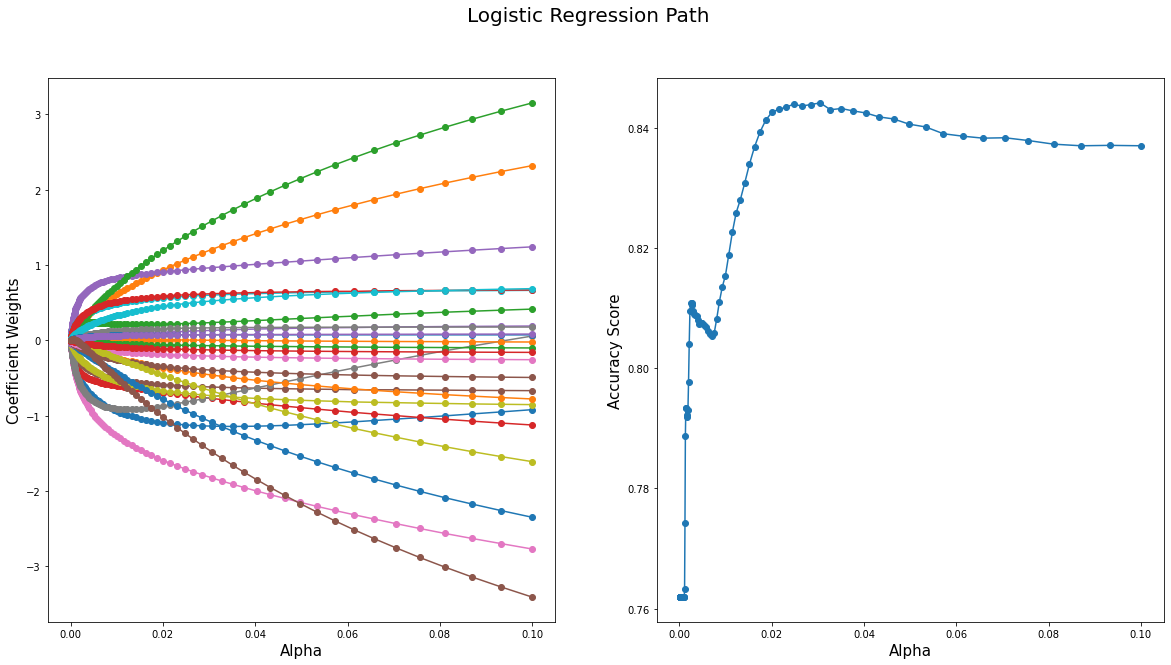

In [95]:
# Define a basic Logisitic Regresion Model that applies L2 (Ridge) regularization
ridge_mod = LogisticRegression(max_iter=10000,penalty='l2')

# Define a list of 100 regularization values to test (from 0.1 to 0.0001)
alphas = 10**np.linspace(-1,-4,100)

coefs_ = [] # Array to store the value of the coefficients for each model
scores_ = [] # Array to store the accuracy for each model

# Go over the regularization values list defined above, train a logreg model for each of the regularization values and evaluate it.
for a in alphas:
    ridge_mod.set_params(C=a) # Set the regularization parameter 
    scores_.append(np.mean(cross_val_score(ridge_mod, X, y, cv=5))) # Appends the accuracy of the model
    coefs_.append(ridge_mod.fit(X,y).coef_.ravel().copy()) # Appends the coefficient of the model

# Conver the coefficient and scores arrays to numpy arrays
coefs_ = np.array(coefs_)
scores_ = np.array(scores_)

# Define the figures to plot the values
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
fig.suptitle('Logistic Regression Path', fontsize=20)

# Coeff Weights Plot
ax1.plot(alphas, coefs_, marker='o')
ymin, ymax = plt.ylim()
ax1.set_ylabel('Coefficient Weights', fontsize = 15)
ax1.set_xlabel('Alpha', fontsize = 15)
ax1.axis('tight')

# Accuracy Plot
ax2.plot(alphas, scores_, marker='o')
ymin, ymax = plt.ylim()
ax2.set_ylabel('Accuracy Score', fontsize = 15)
ax2.set_xlabel('Alpha', fontsize = 15)
ax2.axis('tight')

plt.show()

As you can see in the left figure, the smaller the alpha value (alpha), the larger the regularization and, consequently, the smaller the weights of the coefficients. This is because, if we check the sklearn documentation, we will see that this value is the: "*Inverse of regularization strength*."

When regularization is large enough (i.e., alpha is small), the values of the coefficients are close to 0 (i.e., null model).

 As there is a trade-off between variance (i.e., less over-fitted model --> more regularization) and bias (i.e., learning more from the training set --> less regularization), You must find the optimal alpha value. As you can see in the right figure, this value is achieved with small alpha values (i.e., more regularization). This specific value is not always the same since it depends on your data and the prediction problem. 

To automatize the process of finding the optimal value, you can make use of the LogisticRegressionCV function in sklearn (https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegressionCV.html) that performs CV, testing different hyperparameters (that you can provide) and selecting the optimal one. 

In [145]:
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegressionCV

alphas = 10**np.linspace(-1,-4,100)

ridge_mod_cv = LogisticRegressionCV(max_iter=10000,penalty='l2',Cs=alphas)

results_df.loc[len(results_df)] = ['LR Ridge CV', np.mean(cross_val_score(ridge_mod_cv, X, y, cv=5))]
results_df

,Approach,Accuracy
0,LR Baseline,0.855323
1,LR ChiSquared Selection,0.858456
2,LR Ridge,0.854789
3,LR Ridge CV,0.840655


We do not have many features, so the optimization of the alpha values does not provide a huge improvement. However, in scenarios with more complex datasets this procedure can significantly improve your model performance.

### Lasso

Let's see if Lasso (which actually removes features by making their coefficients equal to 0) improves the unregularized model.

In [146]:
lasso_mod = LogisticRegression(penalty='l1', solver='liblinear')

results_df.loc[len(results_df)] = ['LR Lasso', np.mean(cross_val_score(lasso_mod, X, y, cv=5))]
results_df

,Approach,Accuracy
0,LR Baseline,0.855323
1,LR ChiSquared Selection,0.858456
2,LR Ridge,0.854789
3,LR Ridge CV,0.840655
4,LR Lasso,0.858190


In [147]:
get_feature_importance(lasso_mod.fit(X,y), X.columns)

,variable,coefficient
1,number_project_cat_Very_High,9.570000
12,time_spend_company,7.500000
7,satisfaction_level,3.850000
2,number_project_cat_High,2.990000
4,time_spend_company_cat_Medium,2.310000
19,average_montly_hours,0.830000
0,time_spend_company_cat_Low,0.800000
9,salary_low,0.480000
17,sales_hr,0.170000
24,sales_support,0.110000


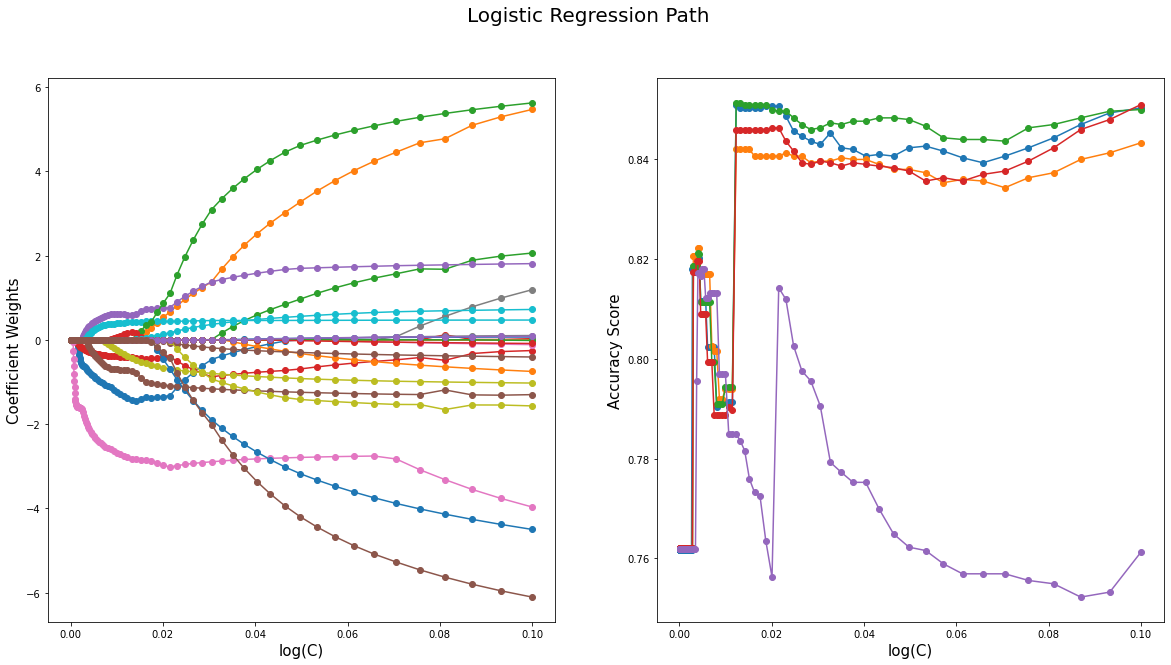

In [101]:
lasso_mod = LogisticRegression(penalty='l1',solver='liblinear')
alphas = 10**np.linspace(-1,-4,100)

coefs_ = []
scores_ = []
for a in alphas:
    lasso_mod.set_params(C=a)
    scores_.append(cross_val_score(lasso_mod, X, y, cv=5))
    coefs_.append(lasso_mod.fit(X,y).coef_.ravel().copy())

coefs_ = np.array(coefs_)
scores_ = np.array(scores_)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
fig.suptitle('Logistic Regression Path', fontsize=20)

# Coeff Weights Plot
ax1.plot(alphas, coefs_, marker='o')
ymin, ymax = plt.ylim()
ax1.set_ylabel('Coefficient Weights', fontsize = 15)
ax1.set_xlabel('log(C)', fontsize = 15)
ax1.axis('tight')

# Accuracy Plot
ax2.plot(alphas, scores_, marker='o')
ymin, ymax = plt.ylim()
ax2.set_ylabel('Accuracy Score', fontsize = 15)
ax2.set_xlabel('log(C)', fontsize = 15)
ax2.axis('tight')

plt.show()

As can be seen in both graphs, Lasso regularization is more abrupt. If you remember from class, Lasso tries to nullify the coefficients (Ridge only tries to smooth their values). As a consequence, when regularization is large enough, many coefficient values are close to 0. You should be very careful when applying this regularization. If the regularization parameter is too restrictive, you will remove most of your features, and consequently, you'll ruin the performance of your model (as you can check in the right figure).

As with Rigde, you can use CV to find the optimal alpha value.

In [148]:
alphas = 10**np.linspace(-1,-4,100)

lasso_mod_cv = LogisticRegressionCV(max_iter=10000,penalty='l1',solver='liblinear',Cs=alphas)

results_df.loc[len(results_df)] = ['LR Lasso CV', np.mean(cross_val_score(lasso_mod_cv, X, y, cv=5))]
results_df

,Approach,Accuracy
0,LR Baseline,0.855323
1,LR ChiSquared Selection,0.858456
2,LR Ridge,0.854789
3,LR Ridge CV,0.840655
4,LR Lasso,0.858190
5,LR Lasso CV,0.836720


The performance is the similar than with Ridge, even worse.

Since Lasso is actually performing Feature Selection (i.e., it nullifies/removes unimportant features) you can apply the trained model to transform your dataset to keep only the features selected by Lasso

In [149]:
model = SelectFromModel(lasso_mod_cv.fit(X,y), prefit=True)
X_new = model.transform(X)
print("Original Number of Features = {} --> Number of features selected by Lasso = {}".format(X.shape[1], X_new.shape[1]))

Original Number of Features = 26 --> Number of features selected by Lasso = 14


Lasso is not removing so many features since we did remove many of them in the ChiSquared selection. It explains why the results of both Lasso and Ridge are so similar.

Let's train a new model by just using these features.

In [150]:
reduced_lasso_mod = LogisticRegression(max_iter=10000,penalty='l1', solver='liblinear')

results_df.loc[len(results_df)] = ['LR Reduced Lasso', np.mean(cross_val_score(reduced_lasso_mod, X_new, y, cv=5))]
results_df

,Approach,Accuracy
0,LR Baseline,0.855323
1,LR ChiSquared Selection,0.858456
2,LR Ridge,0.854789
3,LR Ridge CV,0.840655
4,LR Lasso,0.858190
5,LR Lasso CV,0.836720
6,LR Reduced Lasso,0.862323


In [151]:
get_feature_importance(reduced_lasso_mod.fit(X_new,y), X.columns[model.get_support()])

,variable,coefficient
9,time_spend_company,7.460000
1,number_project_cat_Very_High,6.530000
3,time_spend_company_cat_Medium,2.390000
12,average_montly_hours,0.940000
0,time_spend_company_cat_Low,0.900000
7,salary_low,0.500000
10,sales_RandD,-0.570000
6,salary_high,-1.210000
4,Work_accident_1,-1.470000
5,satisfaction_level_bin,-2.730000


Performance is better and we have achieved it with almost half the features than with the original model. As discussed many times, models using less features are preferable: less complexity, less computation time, more explainable and less prone to overfitting.